# Satisfiability Modulo Theories

Philip Zucker



# Overview

- Glue together domain specific solvers with SAT
- Applications
- Intro Theory Combination
- Egraphs and SMT

# Demo


## Find Stuff

In [2]:
import z3
x,y,z = z3.Ints("x y z")
s = z3.Solver()
s.add(x + y + z == 10)
s.check()
s.model()

[y = 0, z = 0, x = 10]

Or use the command line

In [6]:
%%file /tmp/solve.smt2
(set-logic ALL)
(declare-const x Int)
(declare-const y Int)
(declare-const z Int)
(assert (= (+ x y z) 10))
(check-sat)
(get-model)

Writing /tmp/solve.smt2


In [7]:
! z3 /tmp/solve.smt2

sat
(
  (define-fun y () Int
    0)
  (define-fun z () Int
    0)
  (define-fun x () Int
    10)
)


In [10]:
! cvc5 --produce-models /tmp/solve.smt2

sat
(
(define-fun x () Int 10)
(define-fun y () Int 0)
(define-fun z () Int 0)
)


## Don't Find Stuff (Counterexamples)

In [4]:
import z3
x = z3.BitVec("x", 32)
s = z3.Solver()
thm = x | x == x
s.add(z3.Not(thm))
s.check()

unsat

In [7]:
z3.prove(x | x == x)

proved


In [6]:
import z3
x = z3.BitVec("x", 32)
s = z3.Solver()
thm = x <= x + 1
s.add(z3.Not(thm))
s.check()
s.model()


[x = 2147483647]

# SMT Uses
- Constraint Satisfaction
- Theorem Proving
- Software Verification
- Synthesis

## Constraint Satisfaction
  + Sudoku, N-queens, SEND + MORE = MONEY
  + Graph coloring (register allocation)
  + Scheduling
  + Dependency Resolution
  + https://www.philipzucker.com/compile_constraints/
  + Unison https://unison-code.github.io/

## Theorem proving
  + Sledgehammer
  + lean-smt
  + SMTCoq
  + Knuckledragger


### Knuckledragger

- https://www.kdrag.com
- LCF style proof assistant for SMTLIB logic
- Big Step SMT
- Manual quantifier handling
- Backwards tactics system and many goodies

In [5]:
from kdrag.all import *
kd.prove(smt.ForAll([x], x | x == x))

|= ForAll(x, x | x == x)

In [26]:
import kdrag.theories.logic.zf as zf
P = smt.Const("P", zf.Class)
@kd.Theorem(smt.Not(smt.ForAll([P], zf.is_set(P))))
def russell(l):
    x,A = smt.Consts("x A", zf.Set)
    l.unfold(zf.is_set).unfold(zf.reflects)
    l.assumes(smt.ForAll([P], smt.Exists([A], smt.ForAll([x], zf.elem(x, A) == P[x]))))
    Q = smt.Lambda([x], smt.Not(zf.elem(x, x)))
    l.have(smt.Exists([A], smt.ForAll([x], zf.elem(x, A) == Q[x]))).specialize(0, Q).auto()
    A1 = l.obtain(-1)
    l.have(zf.elem(A1, A1) == Q(A1)).specialize(-1, A1).auto()
    l.show(smt.BoolVal(False), by=[])
russell

|= Not(ForAll(P, is_set(P)))

## Software Verification
- Symbolic Execution
  + CBMC Kani Klee 
- Alive
- F*
- Dafny
- ASMC Assembly Checker https://github.com/philzook58/knuckledragger/tree/main/src/kdrag/contrib/pcode

In [75]:
%%file /tmp/swap.S
.include "/tmp/knuckle.s"
kd_prelude "(declare-const olda (_ BitVec 32))"
kd_prelude "(declare-const oldb (_ BitVec 32))"
 .file "swap.c"
 .text
 .globl swap
 .type swap, @function
swap:
kd_entry myentry "(distinct RSI (bvadd RSI (_ bv1 64)) (bvadd RSI (_ bv2 64)) (bvadd RSI (_ bv3 64)) RDI (bvadd RDI (_ bv1 64)) (bvadd RDI (_ bv2 64)) (bvadd RDI (_ bv3 64)))"
kd_assign save_olda olda "(select ram32 RDI)"
kd_assign save_oldb oldb "(select ram32 RSI)"
.LFB0:
 .cfi_startproc
 endbr64
 movl (%rdi), %eax
 movl (%rsi), %edx
 movl %edx, (%rdi)
 movl %eax, (%rsi)
kd_exit myexit "(and (= (select ram32 RSI) olda) (= (select ram32 RDI) oldb))"
 ret
 .cfi_endproc

Writing /tmp/swap.S


In [76]:
! python3 -m kdrag.contrib.pcode /tmp/swap.S

Processing /tmp/swap.S with language ID x86:LE:64:default using assembler as
Constructing Trace Fragments...
Unexpected SP conflict
Executing SpecStmt: Assign(label='save_olda', addr=4194304, name='olda', expr=ram32[RDI])
Executing SpecStmt: Assign(label='save_oldb', addr=4194304, name='oldb', expr=ram32[RSI])
Executing 0x400000/4: ENDBR64  at (4194304, 0) PCODE IMARK ram[400000:4]
Continuing execution at: 0x400004 trace_id [0] num insns 1
Executing 0x400004/2: MOV EAX,dword ptr [RDI] at (4194308, 0) PCODE IMARK ram[400004:2]
Executing 0x400004/2: MOV EAX,dword ptr [RDI] at (4194308, 1) PCODE unique[11f80:4] = *[ram]RDI
Executing 0x400004/2: MOV EAX,dword ptr [RDI] at (4194308, 2) PCODE EAX = unique[11f80:4]
Executing 0x400004/2: MOV EAX,dword ptr [RDI] at (4194308, 3) PCODE RAX = zext(EAX)
Continuing execution at: 0x400006 trace_id [0] num insns 2
Executing 0x400006/2: MOV EDX,dword ptr [RSI] at (4194310, 0) PCODE IMARK ram[400006:2]
Executing 0x400006/2: MOV EDX,dword ptr [RSI] at (4

# SMT Guts

## SAT Solving
- Triumph of automated reasoning
  + https://x.com/ArminBiere/status/1833515116186546472
- Search + Propagation + Heuristics
- Conflict Directed Clause Learning

## SMT

- Eager - Compile theory problems into SAT
  + Bit Blast
  + Ackermannization - encode congruence closure into SAT
- Lazy
  + Abstract theory propositions as opaque `p`.
  + Very Lazy - SAT Reduces to a conjunction of theory literals
  + Regular Lazy - interleave theory propagation and SAT propagation


## Theories

- Theories are a black box API
- Theories as sets of formulas



### Theory Interface

- https://microsoft.github.io/z3guide/programming/Example%20Programs/User%20Propagator/
- https://z3prover.github.io/api/html/classz3py_1_1_user_propagate_base.html


In [ ]:
class Theory():
    def push(self): ...
    def pop(self): ...
    def create(self, t : ExprRef): ... # notify of term creation
    def fresh(self, s : SortRef) -> ExprRef: ... # create fresh constant of sort s
    def fix(self, t : ExprRef, v : object): ... # assign concrete value to term
    def decide(self, lit : BoolRef, v : bool): ... # assign truth value to literal
    def assert_eq(self, t1 : ExprRef, t2 : ExprRef): ... # assert equality
    def assert_diseq(self, t1 : ExprRef, t2 : ExprRef): ... # assert disequality
    def finalize(self) -> bool: ... # finalize and check satisfiability
    def propagate(self) -> list[BoolRef]: ... # Propagate new facts. Equalities and disequalities
    def explain(self) -> list[BoolRef]: ... # Small set of literals that cause conflict
    

### Example Theories

- Atomic equality
- Uninterpreted Functions
- Arithmetic
  - Intervals `x <= 7`
  - Linear Equality `3x + 2y = z + 4`
  - Two Variable `x - y <= 4`
  - Linear inequality 
  - Tractable theories often show up in abstract interpretations
- Bitvectors
- Arrays
  + First class functions
  + Support for Lambdas but YMMV
- Algebraic Datatypes
- Sequences

## Theory Combination

- Nelson-Oppen
- Shostak
    + `solve` and `canon`
    + https://resources.mpi-inf.mpg.de/departments/rg1/conferences/vtsa08/slides/barret2_smt.pdf


### Nelson Oppen Combination

- Purify
  + flatten `f(f(a) + 1) <= 7 -> [a = e1, f(e1) = e2, e2 + 1 = e3, f(e3) = e4]   
  + Hand off to solvers  [a = e1, f(e1) = e2, f(e3) = e4],  [e2 + 1 = e3, e4 <= 7] 
- Guess or find working arrangement `=` `!=` of shared e1,e2,e3,e4.

### Propagation
- For some theoires propagation works better than 

- Abstract interpreations need to be fast. They have propagation like character usually / latticy
- Communities have their own perspectives
- Intervals
- Octagon domain
- Polyhedral domain

- Model based theory combination

### Theoretical Concerns

- Stably Infinite
    + I suspect this is a model-theoreticy way of saying has a good notion of "fresh"
    + Relaxations
- Convex - Propagates equality good
- Non-Convex - Doesn't propagate equalities good

# EGraphs and SMT

## Minimal Models

- The model returned by z3 is basically an egraph. 
- But not an extremal egraph.

In [71]:
import z3
T = z3.DeclareSort("T")
s = z3.Solver()
a, b, x, y = z3.Consts("a b x y", T)
f = z3.Function("f", T, T)
s.add(f(f(f(a))) == a)
s.add(x == y)
s.check()
s.model()

[a = T!val!0,
 y = T!val!0,
 x = T!val!0,
 f = [T!val!1 -> T!val!2,
      T!val!2 -> T!val!0,
      else -> T!val!1]]

In [74]:
s = z3.Optimize()
a, b = z3.Consts("a b", T)
f = z3.Function("f", T, T)
s.add(f(f(f(a))) == a)
s.add(x == y)
ts = [a, f(a), f(f(a)), f(f(f(a))), x, y]
for i, t in enumerate(ts):
    for t1 in ts[:i]:
        s.add_soft(t != t1) # maximize disequalities
s.check()
s.model() 

[y = T!val!3,
 a = T!val!0,
 x = T!val!3,
 f = [T!val!1 -> T!val!2,
      T!val!2 -> T!val!0,
      else -> T!val!1]]

## SMT Based Egraphs Modulo Theories

- Prototype for Egraphs modulo theories
- Get all SMT theories for free
- https://www.philipzucker.com/brute_eggmt/
- https://www.philipzucker.com/egraph-mt2/


- SMT is oracle for equality
- Throw terms into a set
- Rebuild records oracle equalities in union find
- Bottom up ematching + SMT query for egraph containment

- Supports linear, arrays, polynomials
- Context via `smt.Implies` 



In [28]:
from kdrag.solvers.egraph import EGraph

a = smt.Int("a") 
E = EGraph()
t = (a * 2) / 2
E.add_term(t)
E.simplify_terms()
print(E.extract(t))

a


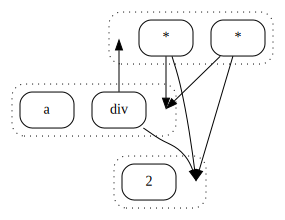

In [29]:
E.dot()


# Resources

- de Moura https://leodemoura.github.io/files/oregon08.pdf
- Tinelli  https://homepage.cs.uiowa.edu/~tinelli/talks/SATSMT-12.pdf
- Bjorner <https://www.youtube.com/watch?v=TgAVIqraCHo&t=227s>
- https://www.philipzucker.com/glue-cvc5-z3/
- https://microsoft.github.io/z3guide/docs/logic/intro/
- https://cvc5.github.io/tutorials/beginners/index.html
- https://smt.st/SAT_SMT_by_example.pdf

# Bits and Bobbles

# Syntax and Semantics

M |= P

Separating by signature does sensibly correspond to how theories are disjoint

multiset rewriting is a decidable theory

EPR
# Quantifiers
- Elimination
- E-matching
- MBQI Model Based Quantifier Instantiation




# What do they give you

- SAT
  - Models - Counterexamples, Holes, Parameters, Solutions
- UNSAT
  - Unsat cores
  - Proofs

## Synthesis. 
    - Guess and check
    - Ruler
    - CF's blog post <https://pypy.org/posts/2024/07/finding-simple-rewrite-rules-jit-z3.html>

Could fill out some kind of constraint compiler demo
ML superoptimize compiler things seem to be taking hold.
